# **Building and deploying Machine Learning models**

## **Abstract**

*'All models are wrong, but some are useful'*  - George Box

The main motivation behind this project was to learn to work with data with no context and try and make sense out of it. We are presented with raw data that contains 15 independent features that are used to describe an instance of some observation. Each feature is labeled from 'A' to 'O'. We do not know what each feature means in terms of what the numbers represent. Another challenge was that the dataset itself was large and complex. With no evident correlations between the independent and the target variables. The count of each class label were not roughly equally distributed with more instances of one class label than the others. Furthermore, there was also not much scope to improve the quality of the data since there were not a lot of incosistencies and noise that could be removed in order to make better predictions. For example, the dataset had no missing values, few columns with outliers, and not much multicollinearity. 

Overall, I found this project to be very intriguing and it was interesting to explore how a model would take in raw data with no context and try to come up with predictions. I quickly learned that the accuracy would not tend to improve with simple models that would take the entire dataset as a whole and find functions to map the input with the output. It would take effort to find out how exactly what features are being used to describe the targets in the first place. Future scope for this project would include using domain knowledge on the different features to try and understand correlations and dependencies. Also, trying to use certain boosting techniques to try and improve the accuracy of relatively weaker models. Additionally, we could also tune the hyperparameters to change certain fitting characteristics in order to improve model performance.

## **Overview**

***Problem Statement***: The main aim of the project is to develop a classification model pipeline that can be used to make predictions on out-of-sample data.

***Relevant literature***: 
- *Anupama Jha, Meenu Dave, Supriya Madan*. "Comparison of Binary Class and Multi-Class Classifier Using Different Data Mining Classification Techniques", 2019, Proceedings of International Conference on Advancements in Computing & Management (ICACM) 2019 (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3464211) 
- *Salma Begum, Ramazan Aygun*. "Greedy hierarchical binary classifiers for multi-class classification of biological data", 2014, Network Modeling Analysis in Health Informatics and Bioinformatics. (https://www.researchgate.net/publication/271913431_Greedy_hierarchical_binary_classifiers_for_multi-class_classification_of_biological_data)
- *Ana Carolina Lorena, Andréde Carvalho, João M. P. Gama*. "A review on the combination of binary classifiers in multiclass problems", Artificial Intelligence Review, 2009. (https://link.springer.com/article/10.1007s10462-009-9114-9)

***Proposed methodology***: The data is first cleaned to remove any evident noise and inconsistencies that may hinder performance. Exploratory Data Analysis (EDA) is used to gather any relevant insights that might help in making the right decisions in terms of model selection and feature importance. The next step would be to assess the feature importance and try to reduce the dimensionality of the data. Principal Component Analysis (PCA) is performed on the dataset in order to reduce the data into 2 principal components that can be used to explain the variance and build a working model that can make decent predictions. The main thing to consider apart from just PCA is to convert the given multi-class classification problem into a set of binary classification tasks. That is, instead of building a model that can classify targets as either 1,2 or 3, we build binary classification models that can classify the data as either belonging to class 1 or not class 1, and class2 or not class 2, and class3 or not class 3. This way each model knows what kind of data belongs to each class type and they can then be combined to give us a model which has learned sets of inputs that can make predicitions on new data. 

## **Data Processing**

### *Importing the libraries*

In [ ]:
!pip install sklearn2pmml
!pip install skl2onnx
!pip install onnxruntime

  Using cached https://files.pythonhosted.org/packages/2e/2e/efe7874c6b92ce4dd262b58a2860e9bf50097c68588114a542b29affca46/skl2onnx-1.8.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/42/f5/82c29029a643dd4de8e0374fe2d5831f50ca58623dd1ee41e0b8df8a7d71/onnxconverter_common-1.8.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3f/9b/54c950d3256e27f970a83cd0504efb183a24312702deed0179453316dbd0/onnx-1.9.0-cp37-cp37m-manylinux2010_x86_64.whl
     |████████████████████████████████| 4.1MB 5.3MB/s 


In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 

from sklearn import tree 
import graphviz 
from sklearn_pandas import DataFrameMapper
from sklearn import decomposition

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.decomposition import PCA 
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn2pmml.decoration import ContinuousDomain
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import sklearn2pmml

from sklearn import metrics 


### *Importing the data*

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/data_public.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
df.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
0,231.420023,-12.210984,217.624839,-15.611916,140.047185,76.904999,131.591871,198.160805,82.873279,127.350084,224.592926,-5.992983,-14.689648,143.072058,153.439659,2
1,-38.019270,-14.195695,9.583547,22.293822,-25.578283,-18.373955,-0.094457,-33.711852,-8.356041,23.792402,4.199023,2.809159,-59.330681,-11.685950,1.317104,3
2,-39.197085,-20.418850,21.023083,19.790280,-25.902587,-19.189004,-2.953836,-25.299219,-6.612401,26.285392,5.911292,6.191587,-56.924996,-4.675187,-1.027830,2
3,221.630408,-5.785352,216.725322,-9.900781,126.795177,85.122288,108.857593,197.640135,82.560019,157.105143,212.989231,-3.621070,-15.469156,135.265859,149.212489,2
4,228.558412,-12.447710,204.637218,-13.277704,138.930529,91.101870,115.598954,209.300011,89.961688,130.299732,201.795100,-1.573922,-15.128603,148.368622,147.492663,3


In [ ]:
df['Class'].unique()

array([2, 3, 1])

In [ ]:
len(df)

1200000

A quick glance of our dataset reveals the following : 
- We have 15 independent variables (A-O) that are being used to describe which class a particular record(row) belongs to.
- Each row of the data is classified into one of three unique class labels (1,2 and 3) 
- We have a total of 1200000 unique instances or records in our dataset.

Our goal is to build a predictive model whose taks is approximating the mapping function from the independent variables and the target class. The main goal is to identify which class/label a new data instance would fall into. 

We do this using a Pipeline built from Scikit-Learn. The purpose of the pipeline is to combine the different steps of processing, model-building and model-testing into one operation. It also allows for hypermater tuning in order to improve the accuracy of our results. Our pipeline will consist of the following steps : 
- Scaling the data 
- Principal Component Analysis (PCA)
- Building the classification model 
- Testing its accuracy 


In [ ]:
## Building a simple pipeline without any preprocessing 

X = df.drop(['Class'], axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, test_size=0.2)

# pipeline steps :
#1. Scaling the data 
#2. Pricipal Component Analysis 
#3. Building a Decision Tree model 
#4. Testing accuracy

pipeline_dt=Pipeline([('scalar',StandardScaler()),
                     ('pca',PCA(n_components=2)),
                     ('dt_classifier',DecisionTreeClassifier(max_depth=3))])    

pipeline_dt.fit(X_train, y_train)
pipeline_dt.score(X_test, y_test)     # accuracy

0.4993172603290554

Let us try and improve on this model by first preprocessing our data. 

### *Preprocessing our data*

What we aim to do from preprocessing the data is check for certain inconsistencies such as missing values in the data, attributes lacking interest, noisy data, outliers, handling categorical values, etc. 

We also use Exploratory Data Analysis(EDA), a complement to inferential statistics which looks to describe the dataset using visualizaitons and other key performance statistics and then summarizing it to gather more insights into our data. This will help aid the model building process by helping us understand what the best hyperparameters would be and which model would be best suited for prediction. 

We will perform the following steps in order to preprocess our data : 
- Exploratory Data Analysis 
- Removing duplicates 
- Handling missing values 
- Outlier treatment 
- Normalizing and Scaling 
- Encoding categorical variables 
- Bivariate analysis 
- Splitting the data into train and test sets 

In [ ]:
## Exploratory Data Analysis 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 16 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   A       1200000 non-null  float64
 1   B       1200000 non-null  float64
 2   C       1200000 non-null  float64
 3   D       1200000 non-null  float64
 4   E       1200000 non-null  float64
 5   F       1200000 non-null  float64
 6   G       1200000 non-null  float64
 7   H       1200000 non-null  float64
 8   I       1200000 non-null  float64
 9   J       1200000 non-null  float64
 10  K       1200000 non-null  float64
 11  L       1200000 non-null  float64
 12  M       1200000 non-null  float64
 13  N       1200000 non-null  float64
 14  O       1200000 non-null  float64
 15  Class   1200000 non-null  int64  
dtypes: float64(15), int64(1)
memory usage: 146.5 MB


We notice that all the indpendent variables in our dataset are floating point numbers and our class label is an integer. There is no requirement to handle data points of an unexpected data type. 

In [ ]:
## checking for missing data 

df.isnull().any()

A        False
B        False
C        False
D        False
E        False
F        False
G        False
H        False
I        False
J        False
K        False
L        False
M        False
N        False
O        False
Class    False
dtype: bool

We find no missing data present in our dataset. However, to be sure, let us also check if there are any special characters present in the data which may cause discrepencies. 

In [ ]:
import string
alphabet = string.ascii_letters+string.punctuation

df.columns.str.strip(alphabet).astype(bool).any()


False

We can conclude that the data does not contain any missing values or  special characters. 

In [ ]:
## Check for duplicate values 
duplicate = df.duplicated()
duplicate.sum()

0

There aren't any duplicate values either. So far, so good. 

Outliers are data points that don't belong to a particular population. They are abnormal observations that lie beyond the range of the other values in the population. 

Identifying outliers using the inter-quartile range(IQR) :
The interquartile range (IQR) is a measure of statistical dispersion. We calculate the IQR by finding the difference between the 75th and the 25th percentiles. It is formally written as IQR = Q3 - Q1, where Q3 is the 75th percentile and Q1 is the 25th percentile.  



In [ ]:
## check for outliers 

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()


A             0
B        200297
C             0
D        200103
E             0
F             0
G             0
H             0
I             0
J             0
K             0
L        198365
M             0
N             0
O             0
Class         0
dtype: int64

We find that the 'B', 'D' and 'L' columns contain outliers in them that need to be treated before proceeding to build the actual model. We can visualize these outliers using boxplots. 

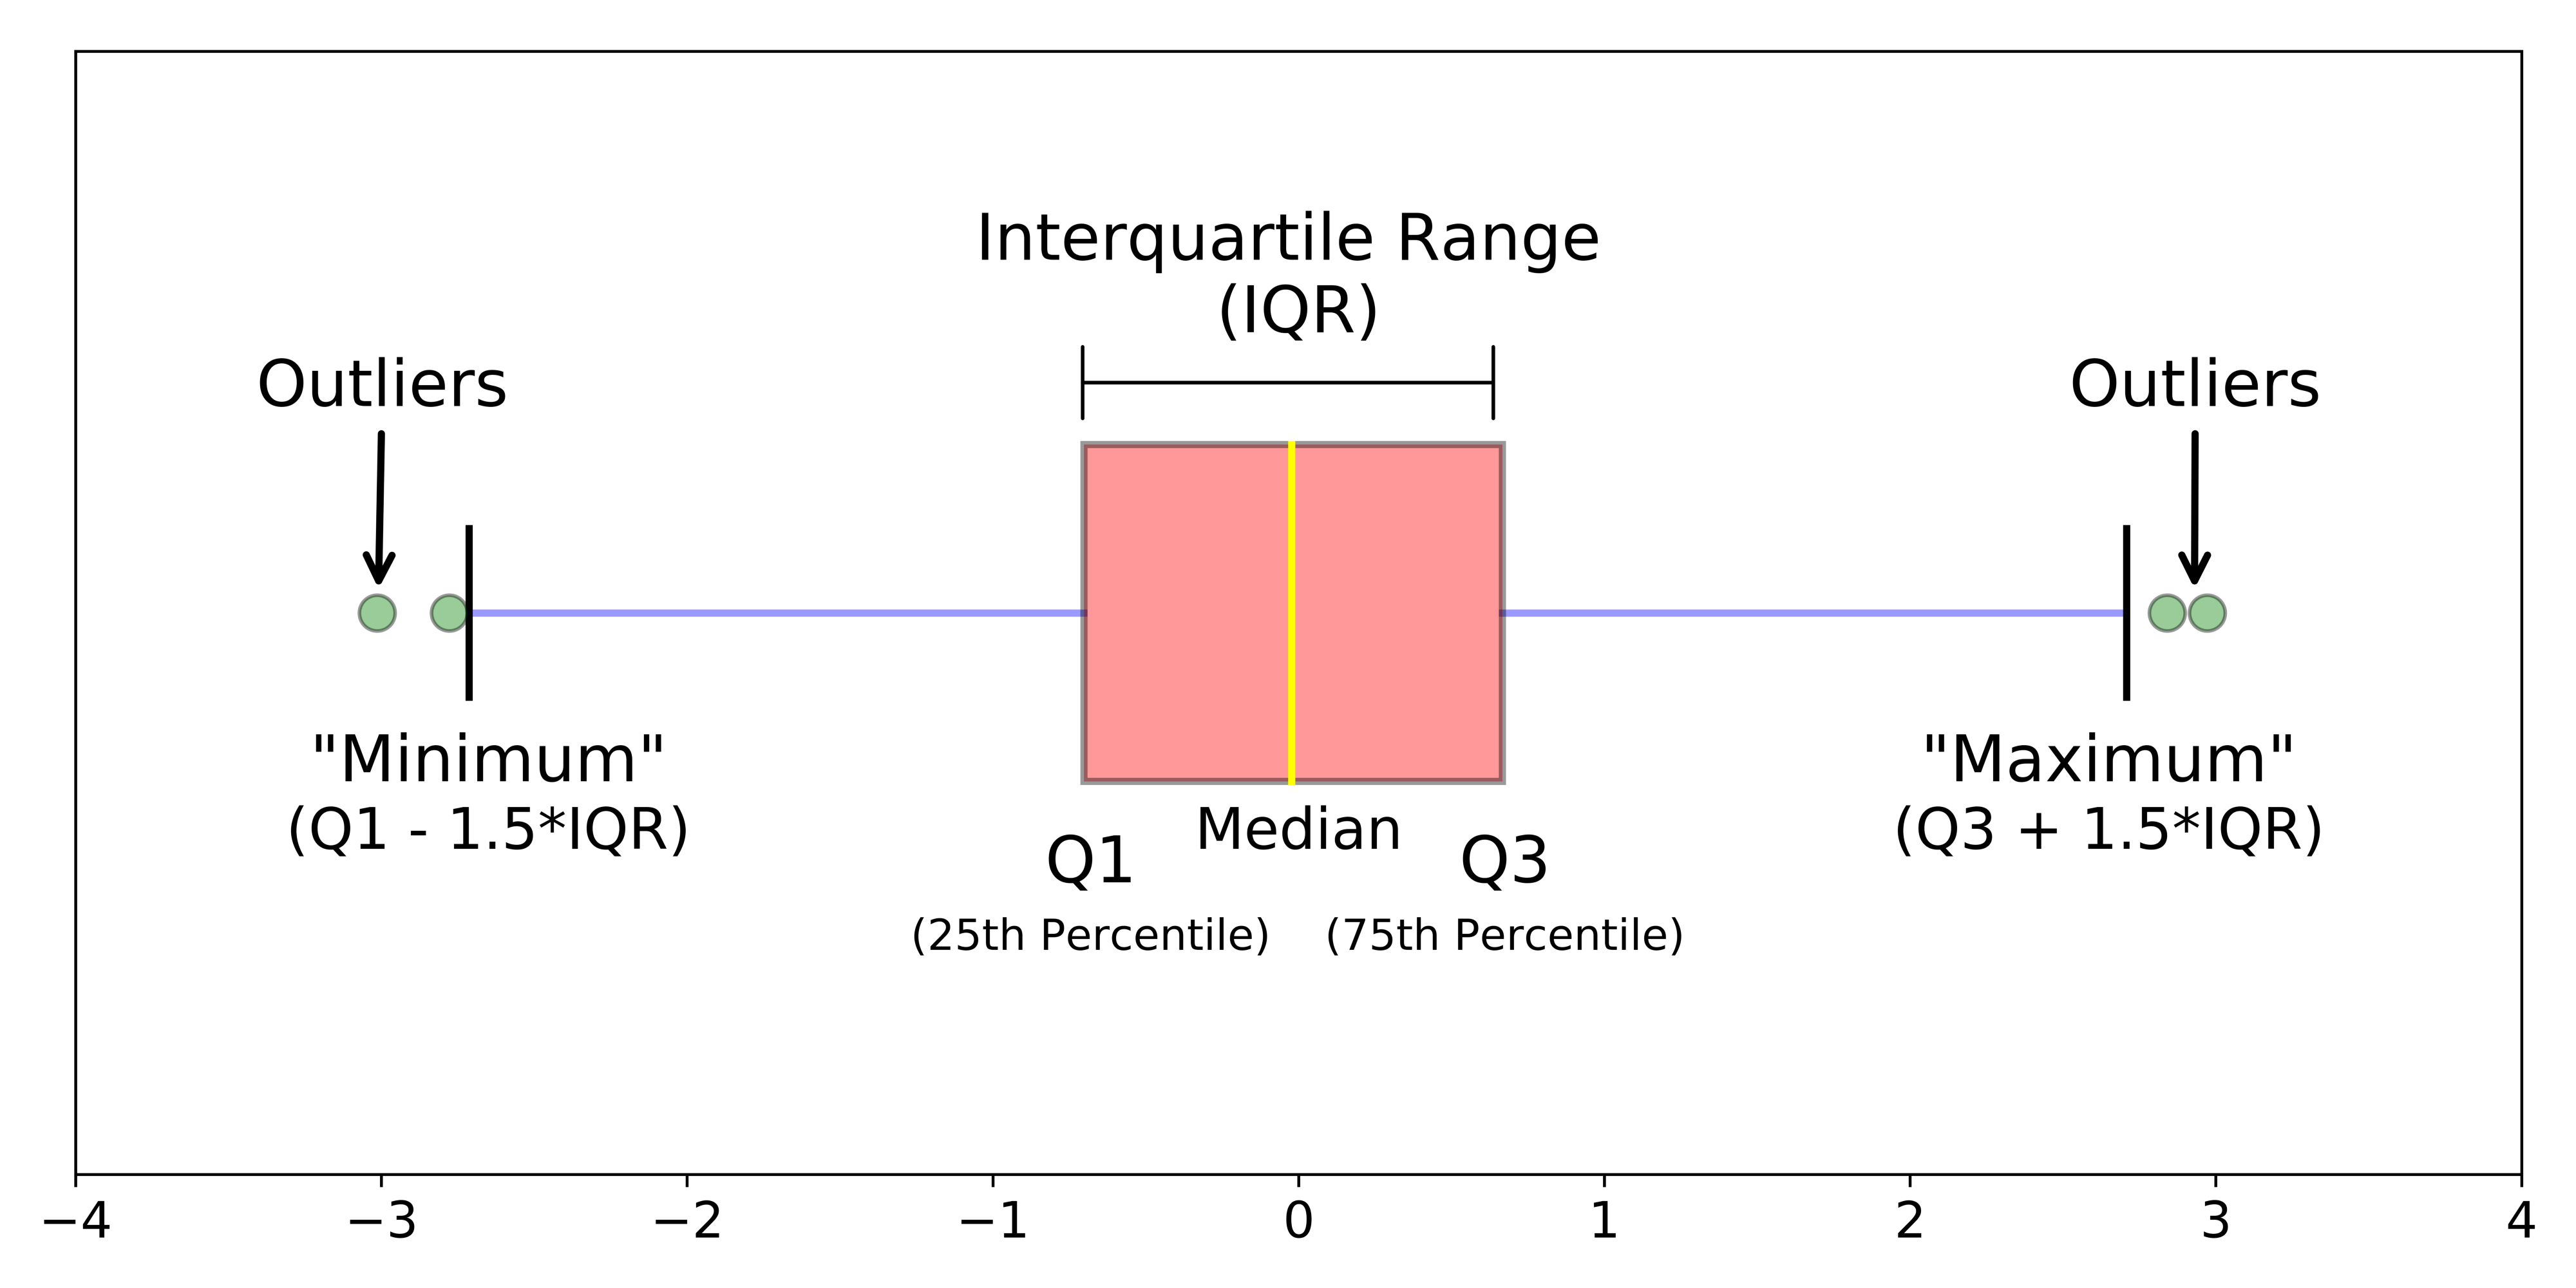

Image source : https://naysan.ca/2020/06/28/interquartile-range-iqr-to-detect-outliers/

[Text(0, 0, 'B'), Text(0, 0, 'D'), Text(0, 0, 'L')]

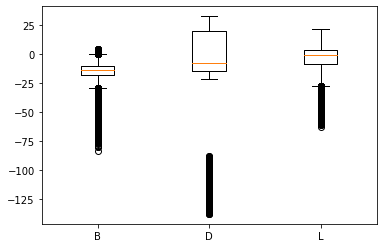

In [ ]:
## Visualizing the outliers 

box_dict = {'B': list(df['B']), 'D': list(df['D']), 'L':list(df['L'])}

fig, ax = plt.subplots()
ax.boxplot(box_dict.values())
ax.set_xticklabels(box_dict.keys())

In contrast, if we visualize a column without any outlier values, we get: 

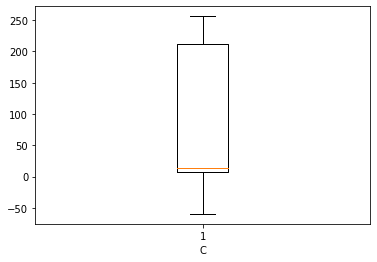

In [ ]:
plt.boxplot(df['C'])
plt.xlabel('C')
plt.show()

In [ ]:
## Dropping rows with ouliers 

len(df)   # Initial lengths 

1200000

In [ ]:
from scipy import stats
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

len(df)     # Length after dropping rows that are outliers 

1193716

Let us now explore if there is any correlation between our variables that might help with feature extraction. 

In [ ]:
## Bivariate analysis 

df.corr()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
A,1.000000,0.454636,0.992084,0.062652,0.990852,0.906120,0.972511,0.988997,0.822571,0.870842,0.969454,0.131911,0.959287,0.954066,0.922130,-0.000639
B,0.454636,1.000000,0.539903,0.863770,0.352570,0.758991,0.618514,0.339316,-0.093470,0.801862,0.247264,0.852674,0.344671,0.196055,0.101499,0.000082
C,0.992084,0.539903,1.000000,0.166794,0.972275,0.943775,0.988382,0.968884,0.758824,0.916090,0.939054,0.230286,0.941695,0.918232,0.876472,-0.000710
D,0.062652,0.863770,0.166794,1.000000,-0.054903,0.467826,0.269441,-0.069713,-0.503776,0.535538,-0.169624,0.948694,-0.049328,-0.223034,-0.320017,0.000120
E,0.990852,0.352570,0.972275,-0.054903,1.000000,0.850749,0.940575,0.997125,0.881999,0.807484,0.989395,0.019809,0.965000,0.980315,0.959836,-0.000665
F,0.906120,0.758991,0.943775,0.467826,0.850749,1.000000,0.969074,0.842980,0.516271,0.989771,0.784333,0.509705,0.825272,0.748627,0.680245,-0.000583
G,0.972511,0.618514,0.988382,0.269441,0.940575,0.969074,1.000000,0.935683,0.684461,0.949428,0.895900,0.326233,0.911413,0.869890,0.818797,-0.000496
H,0.988997,0.339316,0.968884,-0.069713,0.997125,0.842980,0.935683,1.000000,0.888713,0.798734,0.991014,0.005675,0.964863,0.982734,0.963728,-0.000684
I,0.822571,-0.093470,0.758824,-0.503776,0.881999,0.516271,0.684461,0.888713,1.000000,0.448026,0.927925,-0.418360,0.851813,0.944620,0.971547,-0.000756
J,0.870842,0.801862,0.916090,0.535538,0.807484,0.989771,0.949428,0.798734,0.448026,1.000000,0.733811,0.571380,0.783634,0.694936,0.620983,-0.000373


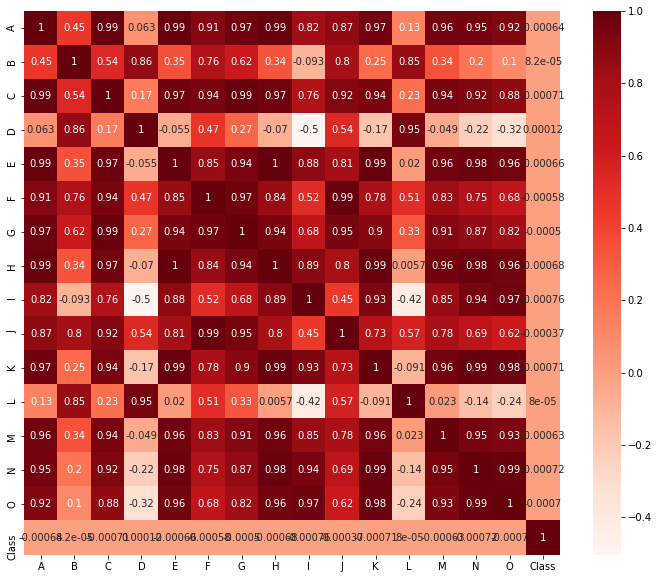

In [ ]:
## Visualizing correlation 

plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

We notice a lot of correlations between the features themselves but no visible correlation between any of the features and the target variable.

Furthermore, let us look at some of the summary statistics for the dataset. 

In [ ]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,1.193716e+06,1.193716e+06,1.193716e+06,1.193716e+06,1.193716e+06,1.193716e+06,1.193716e+06,1.193716e+06,1.193716e+06,1.193716e+06,1.193716e+06,1.193716e+06,1.193716e+06,1.193716e+06,1.193716e+06,1.193716e+06
mean,-8.682936e-02,-1.179830e-01,1.744621e-01,2.945297e-02,-6.603729e-02,-1.804881e-01,4.078992e-02,-3.276651e-02,4.305327e-02,1.642882e-01,1.747227e-01,-1.174406e-02,-3.586773e-01,6.972377e-02,1.323054e-01,1.508529e-02
std,3.718887e-01,7.764584e-02,1.956824e-01,2.400391e-01,2.344030e-01,2.511771e-01,1.533557e-01,2.977592e-01,1.324322e-01,2.405747e-01,1.657364e-01,7.397640e-02,2.732374e-01,1.590093e-01,1.339101e-01,1.119693e-02
min,-5.641228e-01,-3.467873e-01,-2.451355e-01,-5.426783e-01,-4.212605e-01,-5.797971e-01,-2.662464e-01,-4.687216e-01,-2.141106e-01,-4.473066e-01,-1.618353e-01,-2.236202e-01,-7.502839e-01,-2.333903e-01,-1.470151e-01,1.748121e-03
25%,-3.831722e-01,-1.837829e-01,8.731156e-02,-2.710167e-02,-2.757621e-01,-3.426897e-01,-3.819777e-02,-2.977815e-01,-8.606633e-02,2.241379e-01,2.713228e-02,-2.210129e-02,-6.233344e-01,-8.091249e-02,1.626775e-03,4.178373e-03
50%,-2.715352e-01,-1.390441e-01,1.530571e-01,1.379041e-01,-1.884983e-01,-2.808178e-01,1.744693e-02,-2.055153e-01,-2.241985e-02,2.506780e-01,1.210824e-01,-4.003349e-03,-5.576114e-01,4.951466e-03,8.374013e-02,1.150130e-02
75%,4.222780e-01,-2.420942e-02,3.935976e-01,2.214873e-01,2.382795e-01,1.451724e-01,2.135965e-01,3.549691e-01,1.629290e-01,2.869944e-01,3.798394e-01,3.364376e-02,-4.068122e-02,2.526280e-01,2.691281e-01,2.299900e-02
max,4.915968e-01,4.438030e-02,4.694679e-01,3.580803e-01,2.932855e-01,2.255647e-01,3.066592e-01,4.235634e-01,2.972185e-01,4.972386e-01,4.663865e-01,2.487749e-01,1.947968e-02,3.285054e-01,3.314799e-01,4.064299e-02


### *Pricipal Compnent Analysis*

Principal Component Analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity. Because smaller data sets are easier to explore and visualize and make analyzing data much easier and faster for machine learning algorithms without extraneous variables to process.

SOURCE : https://builtin.com/data-science/step-step-explanation-principal-component-analysis 

In [ ]:
df_original = pd.read_csv('/content/drive/MyDrive/Datasets/data_public.csv.gz')
df_copy = df_original.copy()

In [ ]:
pca_df = df_copy

In [ ]:
## Standardizing the data 

labels = ['A', 'B','C','D','E','F','G','H','I','J','K','L','M','N','O']

sc = StandardScaler()

df_scaled = sc.fit_transform(pca_df.drop('Class', axis=1))
df_scaled = pd.DataFrame(df_scaled, columns=labels)
df_scaled = pd.concat([df_scaled, pca_df['Class']], axis=1)
df_scaled.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
0,1.398333,0.457892,1.386800,-0.043941,1.518831,1.136805,1.499176,1.421937,1.182621,1.123217,1.531100,0.048383,1.542774,1.390885,1.402222,2
1,-0.686316,0.320671,-0.589262,0.764323,-0.755534,-0.166762,-0.477999,-0.820431,-0.980689,-0.222670,-0.792750,0.613532,-0.949550,-0.909245,-0.875843,3
2,-0.695429,-0.109594,-0.480605,0.710940,-0.759987,-0.177913,-0.520931,-0.739075,-0.939343,-0.190270,-0.774695,0.830704,-0.815240,-0.805046,-0.910959,2
3,1.322591,0.902156,1.378256,0.077838,1.336854,1.249231,1.157837,1.416902,1.175193,1.509929,1.408750,0.200674,1.499253,1.274864,1.338920,2
4,1.376193,0.441525,1.263438,0.005832,1.503497,1.331041,1.259054,1.529661,1.350708,1.161552,1.290718,0.332113,1.518267,1.469607,1.313165,3


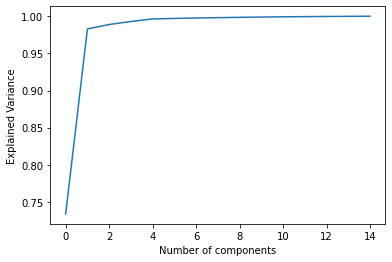

In [ ]:
## Elbow plot to decide optimal number of pricipal components 

pca = decomposition.PCA(n_components=15)
pca.fit(df_scaled.drop(['Class'], axis=1))

plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlabel('Number of components')
plt.ylabel('Explained Variance')
plt.show()

Based on the elbow plot above, we notice that PCA reveals that the optimal number of components that can explain most of the variance in the data is 1. Hence for all our models, we will set the number of principal components to be 1. 

In [ ]:
labels = ['A', 'B','C','D','E','F','G','H','I','J','K','L','M','N','O']
X = pd.DataFrame(data=df_copy.drop('Class', axis=1),
columns=labels)
y = pd.DataFrame(data=df_copy['Class'],
columns=['Class'])
X_train, X_test, y_train, y_test = train_test_split(X,
y,
test_size=0.3)
training_data = pd.concat([X_train,
y_train],
axis=1)
training_data.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
1072504,-33.490647,-14.661206,11.747871,22.346489,-27.721191,-32.512465,1.824240,-21.259593,-2.589216,26.955136,6.399912,1.483937,-54.714254,-1.926332,0.959314,2
713041,232.502535,-16.856704,205.474510,-14.107232,136.581658,83.115921,123.487581,199.993118,92.758674,118.742837,211.817383,-6.204622,-12.564981,149.711416,148.140174,2
450874,-57.255765,-54.097917,-47.377616,-110.555513,-5.144220,-127.730494,-54.644947,-16.453346,54.164936,-93.148273,51.862258,-46.542656,-54.427696,31.323314,56.544112,3
979023,-38.155386,-17.266492,14.639302,17.939150,-23.693301,-26.303813,1.091643,-23.316217,-4.596005,24.001450,-3.167364,-0.570434,-56.687451,-8.030547,1.433857,2
410123,-64.632650,-42.713574,-43.565149,-120.293119,-14.512706,-118.812219,-54.989279,-8.047951,42.408857,-87.328656,37.873110,-38.116028,-61.472808,45.325541,65.779968,1


We then try a brute force method to detect which features hinder the accuracy of our results the most. Based on this, we can decide which features to remove and which features to keep. We loop over all the features and test the accuracy of the model on each feature and decide which one to drop based on the accuracies obtained. 

In [ ]:
##* CODE REFERENCED FROM VICTORIA BELOTTI  *

features = 'ABCDEFGHIJKLMNO'

for i in range(0, len(features)):

  pipeline = PMMLPipeline([
                           ('mapper', DataFrameMapper([
                                                       (X_train.columns.drop([features[i:i+1]]).values,
                                                        [StandardScaler()])])),
                           ('pca', PCA(n_components=1)),
                           ('classifier', DecisionTreeClassifier(max_depth=12))
                           ])
  pipeline.fit(training_data.drop([features[i:i+1]], axis=1), training_data['Class'])

  results = pipeline.predict(X_test)
  acutal = np.concatenate(y_test.values)
  print('Dropped feature:', features[i:i+1], ", Accuracy:", metrics.accuracy_score(acutal, results))

Dropped feature: A , Accuracy: 0.49895555555555554
Dropped feature: B , Accuracy: 0.49896944444444447
Dropped feature: C , Accuracy: 0.4988666666666667
Dropped feature: D , Accuracy: 0.49891944444444447
Dropped feature: E , Accuracy: 0.49879444444444443
Dropped feature: F , Accuracy: 0.498875
Dropped feature: G , Accuracy: 0.4989527777777778
Dropped feature: H , Accuracy: 0.49904444444444446
Dropped feature: I , Accuracy: 0.49869722222222224
Dropped feature: J , Accuracy: 0.4989777777777778
Dropped feature: K , Accuracy: 0.49896944444444447
Dropped feature: L , Accuracy: 0.49893333333333334
Dropped feature: M , Accuracy: 0.49895
Dropped feature: N , Accuracy: 0.49901944444444446
Dropped feature: O , Accuracy: 0.49875555555555556


We notice that the above method does not really help us make decisions on feature importance since all features seem to be giving us more or less the same accuracy. 

I was curious as to how the performance of the model would change if I were to increase the number of principal components to 2 instead of 1. My main thought process was that if two components are sufficient to explain the variance ratio of the dataset, then we can test its performance on the model. 

In [ ]:
from sklearn.preprocessing import StandardScaler

features = ['A', 'B','C','D','E','F','G','H','I','J','K','L','M','N','O']

## Separating out the target variable 

X = pca_df.loc[:, features].values
y = pca_df.loc[:, ['Class']].values

# Standardizing 
X = StandardScaler().fit_transform(X)


In [ ]:
## Implementing PCA 

from sklearn.decomposition import PCA 

pca = PCA(n_components=2)

principalComps = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComps, columns=['p1', 'p2'])

In [ ]:
principalDf.head()

,p1,p2
0,4.799926,0.360278
1,-2.262345,-1.525723
2,-2.193845,-1.387110
3,4.721129,-0.118250
4,4.749759,0.201256


In [ ]:
principalDf = pd.concat([principalDf, pca_df[['Class']]], axis=1)
principalDf.head()

,p1,p2,Class
0,4.799926,0.360278,2
1,-2.262345,-1.525723,3
2,-2.193845,-1.387110,2
3,4.721129,-0.118250,2
4,4.749759,0.201256,3


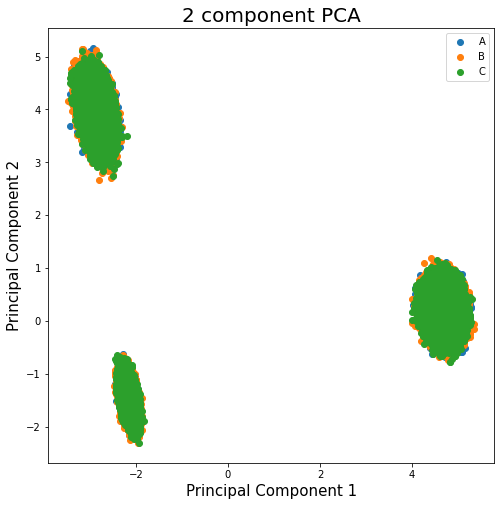

In [ ]:
## visualize pca 

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize=15)
ax.set_ylabel('Principal Component 2', fontsize=15)
ax.set_title('2 component PCA', fontsize=20)

targets = [1, 2, 3]
for t in targets:
  to_keep = principalDf['Class'] == t
  ax.scatter(principalDf.loc[to_keep, 'p1'], principalDf.loc[to_keep, 'p2'])

ax.legend(features)
ax.grid
plt.show()

In [ ]:
pca.explained_variance_ratio_

array([0.73386468, 0.24903022])

In [ ]:
sum(pca.explained_variance_ratio_)

0.9828949000184242

We find something interesting here. 

Taking two principal components, we notice that they are able to explain 98.2% of the variance. We can therefore consider n=2 principal components to be optimal in explaining the variance ratio as well. 

The next task I tried was to come up with the most optimal features using another technique. I figured using similarity between features would be an efficient way to go. And so I tried to select the 5 most similar features based on their similarities. Sklear's SelectKBest function helps us do just that using the Chi Square Distance.

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit(X).transform(X)
X_scaled


array([[0.89073462, 0.80987235, 0.8779829 , ..., 0.72740866, 0.82026832,
        0.85913693],
       [0.10258527, 0.78723745, 0.21941259, ..., 0.24100718, 0.04457839,
        0.07310273],
       [0.09913998, 0.71626466, 0.2556253 , ..., 0.26721914, 0.07971828,
        0.0609862 ],
       ...,
       [0.86894928, 0.75106377, 0.86598024, ..., 0.72631794, 0.8528543 ,
        0.81182299],
       [0.04370846, 0.46993384, 0.05424333, ..., 0.24168541, 0.27271645,
        0.34996566],
       [0.94234337, 0.87639288, 0.86258877, ..., 0.61200446, 0.75515142,
        0.79526219]])

In [ ]:
print(X_scaled[0])    # for reference

[0.89073462 0.80987235 0.8779829  0.71654357 0.90861604 0.83052713
 0.8518387  0.87368383 0.78048193 0.83263085 0.87148368 0.6727923
 0.72740866 0.82026832 0.85913693]


In [ ]:
from sklearn.feature_selection import SelectKBest, chi2 

X_new = SelectKBest(chi2, k=5).fit_transform(X_scaled, y)
X_new

array([[0.89073462, 0.8779829 , 0.71654357, 0.87368383, 0.78048193],
       [0.10258527, 0.21941259, 0.93923052, 0.03176728, 0.07591281],
       [0.09913998, 0.2556253 , 0.92452282, 0.06231308, 0.08937904],
       ...,
       [0.86894928, 0.86598024, 0.73817325, 0.88009701, 0.76335731],
       [0.04370846, 0.05424333, 0.08953574, 0.11858609, 0.56500229],
       [0.94234337, 0.86258877, 0.71981219, 0.86702489, 0.79852367]])

In [ ]:
print(X_new[0])

[0.89073462 0.8779829  0.71654357 0.87368383 0.78048193]


If we compare the above result with the first row of the scaled data, we can map the column names as : ACDHI

Therefore, based on the selecting features on distance similarity, we have come up with the 5 best features to choose for our model : [A, C, D, H, I]. Let us try to build our pipeline using these new features only. 

In [ ]:
new_df = df_copy[['A', 'C', 'D', 'H', 'I', 'Class']]
new_df.head()

,A,C,D,H,I,Class
0,231.420023,217.624839,-15.611916,198.160805,82.873279,2
1,-38.019270,9.583547,22.293822,-33.711852,-8.356041,3
2,-39.197085,21.023083,19.790280,-25.299219,-6.612401,2
3,221.630408,216.725322,-9.900781,197.640135,82.560019,2
4,228.558412,204.637218,-13.277704,209.300011,89.961688,3


In [ ]:
X_new = new_df.drop(['Class'], axis=1)
y_new = new_df['Class']

X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y_new, stratify=y, test_size=0.2)


In [ ]:
## Decision Tree Pipeline 

pipeline_dt_new = Pipeline([('scalar',StandardScaler()),
                     ('pca',PCA(n_components=2)),
                     ('dt_classifier',DecisionTreeClassifier(max_depth=3))])

pipeline_dt.fit(X_new_train, y_new_train)
pipeline_dt.score(X_new_test, y_new_test)


0.4993208333333333

Unfortunately, we do not notice any improvements in accuracy using the K-Best distance similarity metric to reduce the number of features to the most important features.

My next approach was to try different model pipelines on the data and see if I can receive a better accuracy. The models I tried were : 
- Logistic Regression 
- Decision Tree Classifier
- Random Forest Classifier 
- Naive-Bayes Classifier 


In [ ]:
## Creating pipelines for the different classifiers 

## Logistic Regression 

pipeline_lr=Pipeline([('scalar1',StandardScaler()),
                     ('pca1',PCA(n_components=2)),
                     ('lr_classifier',LogisticRegression(random_state=10))])

pipeline_lr.fit(X_train, y_train)
score = pipeline_lr.score(X_test, y_test)
pred = pipeline_lr.predict(X_test)
acc = metrics.accuracy_score(y_test, pred)
print('Classification report:')
print(metrics.classification_report(y_test, pred))
print('Accuracy score: ', acc)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score : 0.4991777777777778
Classification report:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00     59804
           2       0.50      1.00      0.67    179704
           3       0.00      0.00      0.00    120492

    accuracy                           0.50    360000
   macro avg       0.17      0.33      0.22    360000
weighted avg       0.25      0.50      0.33    360000

Accuracy:  0.4991777777777778


In [ ]:
## Decision Tree 

pipeline_dt=Pipeline([('scalar2',StandardScaler()),
                     ('pca2',PCA(n_components=2)),
                     ('dt_classifier',DecisionTreeClassifier(max_depth=3, random_state=0))])

pipeline_dt.fit(X_train, y_train)
score2 = pipeline_dt.score(X_test, y_test)
pred2 = pipeline_dt.predict(X_test)
acc2 = metrics.accuracy_score(y_test, pred2)
print('Classification report:')
print(metrics.classification_report(y_test, pred2))
print('Accuracy score: ', acc2)

Classification report:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00     59804
           2       0.50      1.00      0.67    179704
           3       0.25      0.00      0.00    120492

    accuracy                           0.50    360000
   macro avg       0.25      0.33      0.22    360000
weighted avg       0.33      0.50      0.33    360000

Accuracy score:  0.49917222222222224


In [ ]:
## Random Forest 

pipeline_rf = Pipeline([('scalar3',StandardScaler()),
                     ('pca3',PCA(n_components=2)),
                     ('rf_classifier',RandomForestClassifier(max_depth=5, n_estimators=5))])

pipeline_rf.fit(X_train, y_train)
score3 = pipeline_rf.score(X_test, y_test)
pred3 = pipeline_rf.predict(X_test)
acc3 = metrics.accuracy_score(y_test, pred3)
print('Classification report:')
print(metrics.classification_report(y_test, pred3))
print('Accuracy score: ', acc3)

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Classification report:
              precision    recall  f1-score   support

           1       0.12      0.00      0.00     59804
           2       0.50      1.00      0.67    179704
           3       0.33      0.00      0.00    120492

    accuracy                           0.50    360000
   macro avg       0.32      0.33      0.22    360000
weighted avg       0.38      0.50      0.33    360000

Accuracy score:  0.4991388888888889


In [ ]:
## Naive Bayes Classifier 

pipeline_nb=Pipeline([('scalar4',StandardScaler()),
                     ('pca4',PCA(n_components=2)),
                     ('nb_classifier',GaussianNB())])

pipeline_nb.fit(X_train, y_train)
score4 = pipeline_nb.score(X_test, y_test)
pred4 = pipeline_nb.predict(X_test)
acc4 = metrics.accuracy_score(y_test, pred4)
print('Classification report:')
print(metrics.classification_report(y_test, pred4))
print('Accuracy score: ', acc4)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification report:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00     59804
           2       0.50      1.00      0.67    179704
           3       0.00      0.00      0.00    120492

    accuracy                           0.50    360000
   macro avg       0.17      0.33      0.22    360000
weighted avg       0.25      0.50      0.33    360000

Accuracy score:  0.4991777777777778


We note that changing the model gives us very similar results. This is probably due to the fact that there were no evident correlations to learn between the features and the target varaible and hence changing the type of learning function or the shape of the line of fit would not necessarily improve the model. 

### *Treating the multi-class classification problem as several binary classification problems*

The next thing I tried was to split the multi-calss classification procedure into steps of binary classifications. Implying to train a model to learn to classify instances to 'Class A' and 'Not Class A' instead of 'Class A', 'Class B', and 'Class C'. Similarly for 'Class B'/'Class C' and 'not Class B/not Class C'. 

Model 1 : [1, not 1]   
Model 2 : [2, not 2]  
Model 3 : [3, not 3]  

Let us first try to build a model that can classify instances into 'Class 1' and 'not Class 1' 

In [ ]:
df_copy.loc[(df_copy['Class'] == 2) | (df_copy['Class'] == 3), 'Class' ] = 0


In [ ]:
df_copy.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
0,231.420023,-12.210984,217.624839,-15.611916,140.047185,76.904999,131.591871,198.160805,82.873279,127.350084,224.592926,-5.992983,-14.689648,143.072058,153.439659,0
1,-38.019270,-14.195695,9.583547,22.293822,-25.578283,-18.373955,-0.094457,-33.711852,-8.356041,23.792402,4.199023,2.809159,-59.330681,-11.685950,1.317104,0
2,-39.197085,-20.418850,21.023083,19.790280,-25.902587,-19.189004,-2.953836,-25.299219,-6.612401,26.285392,5.911292,6.191587,-56.924996,-4.675187,-1.027830,0
3,221.630408,-5.785352,216.725322,-9.900781,126.795177,85.122288,108.857593,197.640135,82.560019,157.105143,212.989231,-3.621070,-15.469156,135.265859,149.212489,0
4,228.558412,-12.447710,204.637218,-13.277704,138.930529,91.101870,115.598954,209.300011,89.961688,130.299732,201.795100,-1.573922,-15.128603,148.368622,147.492663,0


In [ ]:
df_1 = df_copy

In [ ]:
df_1['Class'].unique()

array([0, 1])

In [ ]:
X1 = df_1.drop(['Class'], axis=1)
y1 = df_1['Class']

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, stratify=y, test_size=0.2)

pipeline_rf1 = Pipeline([('scaler',StandardScaler()),
                     ('pca',PCA(n_components=2)),
                     ('rf_classifier',RandomForestClassifier(max_depth=5))])

pipeline_rf1.fit(X_train1, y_train1)
pipeline_rf1.score(X_test1, y_test1)

0.8333416666666666

We see a better perfromance in the model pipeline when we train it on a single target class by considering the other two classes as a single entity (In this case, 1 and not 1. 

Let us now try and model for classes 2 and 3.

In [ ]:
df_original.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
0,231.420023,-12.210984,217.624839,-15.611916,140.047185,76.904999,131.591871,198.160805,82.873279,127.350084,224.592926,-5.992983,-14.689648,143.072058,153.439659,2
1,-38.019270,-14.195695,9.583547,22.293822,-25.578283,-18.373955,-0.094457,-33.711852,-8.356041,23.792402,4.199023,2.809159,-59.330681,-11.685950,1.317104,3
2,-39.197085,-20.418850,21.023083,19.790280,-25.902587,-19.189004,-2.953836,-25.299219,-6.612401,26.285392,5.911292,6.191587,-56.924996,-4.675187,-1.027830,2
3,221.630408,-5.785352,216.725322,-9.900781,126.795177,85.122288,108.857593,197.640135,82.560019,157.105143,212.989231,-3.621070,-15.469156,135.265859,149.212489,2
4,228.558412,-12.447710,204.637218,-13.277704,138.930529,91.101870,115.598954,209.300011,89.961688,130.299732,201.795100,-1.573922,-15.128603,148.368622,147.492663,3


In [ ]:
df_2 = df_original.copy()

In [ ]:
df_2.loc[(df_2['Class'] == 1) | (df_2['Class'] == 3), 'Class' ] = 0


In [ ]:
df_2.head() 

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
0,231.420023,-12.210984,217.624839,-15.611916,140.047185,76.904999,131.591871,198.160805,82.873279,127.350084,224.592926,-5.992983,-14.689648,143.072058,153.439659,2
1,-38.019270,-14.195695,9.583547,22.293822,-25.578283,-18.373955,-0.094457,-33.711852,-8.356041,23.792402,4.199023,2.809159,-59.330681,-11.685950,1.317104,0
2,-39.197085,-20.418850,21.023083,19.790280,-25.902587,-19.189004,-2.953836,-25.299219,-6.612401,26.285392,5.911292,6.191587,-56.924996,-4.675187,-1.027830,2
3,221.630408,-5.785352,216.725322,-9.900781,126.795177,85.122288,108.857593,197.640135,82.560019,157.105143,212.989231,-3.621070,-15.469156,135.265859,149.212489,2
4,228.558412,-12.447710,204.637218,-13.277704,138.930529,91.101870,115.598954,209.300011,89.961688,130.299732,201.795100,-1.573922,-15.128603,148.368622,147.492663,0


In [ ]:
df_2['Class'].unique()

array([2, 0])

In [ ]:
X2 = df_2.drop(['Class'], axis=1)
y2 = df_2['Class']

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify=y, test_size=0.2)

pipeline_rf2 = Pipeline([('scaler',StandardScaler()),
                     ('pca',PCA(n_components=2)),
                     ('rf_classifier',RandomForestClassifier(max_depth=5))])

pipeline_rf2.fit(X_train2, y_train2)
pipeline_rf2.score(X_test2, y_test2)

0.499975

In [ ]:
df_3 = df_original.copy()
df_3.loc[(df_3['Class'] == 1) | (df_3['Class'] == 2), 'Class' ] = 0
df_3['Class'].unique()

array([0, 3])

In [ ]:
X3 = df_3.drop(['Class'], axis=1)
y3 = df_3['Class']

In [ ]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, stratify=y, test_size=0.2)

pipeline_rf3 = Pipeline([('scaler',StandardScaler()),
                     ('pca',PCA(n_components=2)),
                     ('rf_classifier',RandomForestClassifier(max_depth=5))])

pipeline_rf3.fit(X_train3, y_train3)
pipeline_rf3.score(X_test3, y_test3)

0.6660166666666667

As we can see, training binary classifiers on our data seems to improve the accuracy to a certain extent. 

Model accuracies :

- 1 and not 1 : 83.33%
- 2 and not 2 : 49.99%
- 3 and not 3 : 66.6%

Let us now combine these pipelines into a single model pipeline that can hopefully fit the entire dataset. We use sklearn's VotingClassifier to combine  multiple models.

In [ ]:
from sklearn.ensemble import VotingClassifier

vclf = VotingClassifier(estimators = [('rf1', pipeline_rf1), ('rf2', pipeline_rf2), ('rf3', pipeline_rf3)], voting='hard')


In [ ]:
vclf.fit(X_train, y_train)
vclf.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4991777777777778

In [ ]:
pipeline_vclf = Pipeline([('scaler',StandardScaler()),
                     ('pca',PCA(n_components=2)),
                     ('vclf_classifier',VotingClassifier(estimators=[('rf1', pipeline_rf1), ('rf2', pipeline_rf2), ('rf3', pipeline_rf3)], voting='hard'))])

pipeline_vclf.fit(X_train, y_train)
pipeline_vclf.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4991777777777778

Now, my hypotesis was that considering the fact that most of the instances in our main dataset are classified into class 2, we could create two binary classification models : one that classifies instances for just targets 'class 2' and 'not class 2' and another model that classifies 'class 1' and 'class 3'. And then combining these two models to make predictions on our main dataset could help create a working model. 

In [ ]:
## Model to classify 1 and 3 

df_13 = df_original.copy()
df_13.drop(df_13[df_13['Class'] == 2].index, inplace=True)
df_13['Class'].unique()

array([3, 1])

In [ ]:
len(df_13)

600772

In [ ]:
X13 = df_13.drop(['Class'], axis=1)
y13 = df_13['Class']

In [ ]:
X_train13, X_test13, y_train13, y_test13 = train_test_split(X13, y13, test_size=0.2)


In [ ]:
X_train13, X_test13, y_train13, y_test13 = train_test_split(X13, y13,test_size=0.2)

pipeline_rf13 = Pipeline([('scaler',StandardScaler()),
                     ('pca',PCA(n_components=2)),
                     ('rf_classifier',RandomForestClassifier(max_depth=5))])

pipeline_rf13.fit(X_train13, y_train13)
pipeline_rf13.score(X_test13, y_test13)

0.6686613124713912

Now, we combine this model with the one that was able to classify class 2 alone and model the train dataset.

In [ ]:
pipeline_vclf = Pipeline([('scaler',StandardScaler()),
                     ('pca',PCA(n_components=2)),
                     ('vclf_classifier',VotingClassifier(estimators=[('rf13', pipeline_rf13), ('rf2', pipeline_rf2)], voting='hard'))])

pipeline_vclf.fit(X_train, y_train)
pipeline_vclf.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4991777777777778

We notice the same accuracy as before.

Finally, I tried to combine the models that can classify [Class 2, Class 3], [Class 2, Class 1] and [Class 1 and Class3] 

In [ ]:
## Class 1 and Class 2

df_12 = df_original.copy()
df_12.drop(df_12[df_12['Class'] == 3].index, inplace=True)
df_12['Class'].unique()

array([2, 1])

In [ ]:
X12 = df_12.drop(['Class'], axis=1)
y12 = df_12['Class']

In [ ]:
X_train12, X_test12, y_train12, y_test12 = train_test_split(X12, y12, test_size=0.2)


In [ ]:
X_train12, X_test12, y_train12, y_test12 = train_test_split(X12, y12,test_size=0.2)

pipeline_rf12 = Pipeline([('scaler',StandardScaler()),
                     ('pca',PCA(n_components=2)),
                     ('rf_classifier',RandomForestClassifier(max_depth=5))])

pipeline_rf12.fit(X_train12, y_train12)
pipeline_rf12.score(X_test12, y_test12)

0.7499499512024224

In [ ]:
## Class 2 and 3 

df_23 = df_original.copy()
df_23.drop(df_23[df_23['Class'] == 1].index, inplace=True)
df_23['Class'].unique()

array([2, 3])

In [ ]:
X23 = df_23.drop(['Class'], axis=1)
y23 = df_23['Class']

In [ ]:
X_train23, X_test23, y_train23, y_test23 = train_test_split(X23, y23, test_size=0.2)


In [ ]:
X_train23, X_test23, y_train23, y_test23 = train_test_split(X23, y23,test_size=0.2)

pipeline_rf23 = Pipeline([('scaler',StandardScaler()),
                     ('pca',PCA(n_components=2)),
                     ('rf_classifier',RandomForestClassifier(max_depth=5))])

pipeline_rf23.fit(X_train23, y_train23)
pipeline_rf23.score(X_test23, y_test23)

0.5996990030099699

Now we combine the three models.

## **Final Model**

In [ ]:
pipeline_vclf123 = Pipeline([('scaler',StandardScaler()),
                     ('pca',PCA(n_components=2)),
                     ('vclf_classifier',VotingClassifier(estimators=[('rf13', pipeline_rf13), ('rf12', pipeline_rf12), ('rf23', pipeline_rf23)], voting='hard'))])

pipeline_vclf.fit(X_train, y_train)
pipeline_vclf.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4991777777777778

This is the final model that we will use to make predictions.

### ONNX

In [ ]:
from skl2onnx import  convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

onnx_model_path = '/content/drive/MyDrive/Datasets/AkhilSrinath_final_model.onnx'

num_features = 15
initial_type = [('float_input', FloatTensorType([None, num_features]))]
onx = convert_sklearn(pipeline_vclf123, initial_types=initial_type)
with open(onnx_model_path, 'wb') as f:
  f.write(onx.SerializeToString())

RuntimeError: ignored

We observe that ONNX is having troubles converting the VotingClassifier model from sklearn. Hence, we use the RandomForestClassifier that we built initially to create the onnx file that can make predictions on our out-of-sample data. 

### Creating .onnx file 

In [ ]:
from skl2onnx import  convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

onnx_model_path = '/content/drive/MyDrive/Datasets/AkhilSrinath_final_model.onnx'

num_features = 15
initial_type = [('float_input', FloatTensorType([None, num_features]))]
onx = convert_sklearn(pipeline_rf, initial_types=initial_type)
with open(onnx_model_path, 'wb') as f:
  f.write(onx.SerializeToString())

### Compute predictions with ONNX runtime

In [ ]:
import onnxruntime as rt
import numpy

sess = rt.InferenceSession(onnx_model_path)
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name

pred_onx = sess.run(None, {input_name: X_test.values.astype(np.float32)})[0]
print(pred_onx)

[2 2 2 ... 2 2 2]


As we can see, the .onnx file is able to make predictions on out-of-sample data. 

## **Conclusion**

In this project, we attempted various procedures to study the data and find patterns that would help in identifying ways to model the data and classify instances. The best method that we were able to find was to try and convert the multi-class classification problem into a set of binary classification problems. We found that when the model was trained on  each independent target class while treating the other two class types as a single entity, the model showed better accuracy. For example, when the model was trained on classifying target class 1 while combining the other two class labels as "not 1", we were able to achieve and accuracy of 83%. However, this model can only learn how to classify class label 1. Similarly, we built binary classification models that were able to classify other combinations of class labels. So, we can conclude that a positive result from the project is that we were able to develop pretty accurate binary classification models that can predict class labels of one type seperately as either 'Class 1' or 'not Class 1' and 'Class 2' or 'not Class 2' and 'Class 3' or 'not Class 3'. However, the major caveat is that when we attempt to combine the binary classification models, the model accuracy drops down to 49%. This allows scope to research on how to effectively combine the binary models into a single model that has learned from its constituent models and can eventually make decent predictions on out-of-sample data. 

## **Data Sources**

- Scikit-Learn Pipelines : https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf 

- Outlier detection and treatment : https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

- PCA : https://builtin.com/data-science/step-step-explanation-principal-component-analysis 

- Notebook by Victoria Belotti (Blackboard) 

- Combining models using VotingClassifier : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier 



## **Source Code**

- https://pandas.pydata.org/
- http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
- https://scikit-learn.org/ 
- http://scikit-learn.org/stable/modules/ensemble.html
- https://stackoverflow.com/questions/21506128/best-way-to-combine-probabilistic-classifiers-in-scikit-learn



## **Bibliography**

- *Anupama Jha, Meenu Dave, Supriya Madan*. "Comparison of Binary Class and Multi-Class Classifier Using Different Data Mining Classification Techniques", 2019, Proceedings of International Conference on Advancements in Computing & Management (ICACM) 2019 (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3464211) 
- *Salma Begum, Ramazan Aygun*. "Greedy hierarchical binary classifiers for multi-class classification of biological data", 2014, Network Modeling Analysis in Health Informatics and Bioinformatics. (https://www.researchgate.net/publication/271913431_Greedy_hierarchical_binary_classifiers_for_multi-class_classification_of_biological_data)
- *Ana Carolina Lorena, Andréde Carvalho, João M. P. Gama*. "A review on the combination of binary classifiers in multiclass problems", Artificial Intelligence Review, 2009. (https://link.springer.com/article/10.1007/
